In [42]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import serial
import time
import numpy as np
import keras
from keras.preprocessing import image
import cv2
import imutils
import numpy as np

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense

In [43]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('HD/train',target_size = (64, 64),batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory('HD/test',
                                             target_size = (64, 64),batch_size = 32,class_mode = 'binary')





Found 5966 images belonging to 6 classes.
Found 572 images belonging to 6 classes.


In [44]:

# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 6, activation = 'softmax'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])




In [45]:

# Part 2 - Fitting the CNN to the images

r=classifier.fit(training_set,epochs = 5,validation_data = test_set)

Epoch 1/5
187/187 [==============================] - 27s 141ms/step - loss: 0.2508 - accuracy: 0.9438 - val_loss: 7.2043 - val_accuracy: 0.6486
Epoch 2/5
187/187 [==============================] - 28s 150ms/step - loss: 0.0380 - accuracy: 0.9888 - val_loss: 8.7732 - val_accuracy: 0.6503
Epoch 3/5
187/187 [==============================] - 29s 153ms/step - loss: 0.0341 - accuracy: 0.9906 - val_loss: 9.2627 - val_accuracy: 0.6503
Epoch 4/5
187/187 [==============================] - 34s 181ms/step - loss: 0.0308 - accuracy: 0.9916 - val_loss: 9.4206 - val_accuracy: 0.6503
Epoch 5/5
187/187 [==============================] - 29s 157ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 10.5345 - val_accuracy: 0.6538


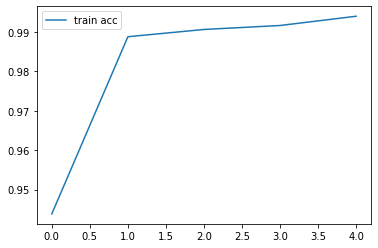

<Figure size 432x288 with 0 Axes>

In [46]:
from matplotlib import pyplot as plt

plt.plot(r.history['accuracy'], label='train acc')


plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
import serial
import time
def write_read(x):
    data =  arduino.write(bytes(x, 'utf-8'))
    return data


In [26]:
arduino = serial.Serial(port='COM4', baudrate=9600, timeout=.5)

In [27]:
global filename
global classifier


bg = None
playcount = 0
names = ['b', 'f', 'l', 'n', 'r', 's']
bgModel = cv2.createBackgroundSubtractorMOG2(0, 50)

In [28]:
def run_avg(image, aWeight):
    global bg
    if bg is None:
        bg = image.copy().astype("float")
        return
    cv2.accumulateWeighted(image, bg, aWeight)

def segment(image, threshold=25):
    global bg
    diff = cv2.absdiff(bg.astype("uint8"), image)
    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]
    ( cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return
    else:
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)


def webcamPredict():
    
    oldresult = 'none'
    nval=0
    count = 0
    fgbg2 = cv2.createBackgroundSubtractorKNN(); 
    aWeight = 0.5
    camera = cv2.VideoCapture(0)
    top, right, bottom, left = 10, 350, 325, 690
    num_frames = 0
    while(True):
        (grabbed, frame) = camera.read()
        frame = imutils.resize(frame, width=700)
        frame = cv2.flip(frame, 1)
        clone = frame.copy()
        (height, width) = frame.shape[:2]
        roi = frame[top:bottom, right:left]
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (41, 41), 0)
        if num_frames < 30:
            run_avg(gray, aWeight)
        else:
            temp = gray
            hand = segment(gray)
            if hand is not None:
                (thresholded, segmented) = hand
                cv2.drawContours(clone, [segmented + (right, top)], -1, (0, 0, 255))      
                roi = frame[top:bottom, right:left]
                roi = fgbg2.apply(roi); 
                cv2.imwrite("test.jpg",roi)
                img = cv2.imread("test.jpg")
                img = cv2.resize(img, (64, 64))
                img = img.reshape(1, 64, 64, 3)
                img = np.array(img, dtype='float32')
                img /= 255
                predict = classifier.predict(img)
                value = np.amax(predict)
                cl = np.argmax(predict)
                result = names[np.argmax(predict)]
                if value >= 0.99:
                    #For the following logic to work, no-motion has to be shown once mandotorily in the beginning 
                    if(result=='n' and nval<1): #will only allow no-motion the first time
                        print(str(value)+" "+str(result))
                        value = write_read(result)
                        nval=1
                    elif(result!='n'): #will make the motion continues even if the hand is shown once
                        print(str(value)+" "+str(result))
                        value = write_read(result)
                        #time.sleep(3)  #automatically the robot will stop after 3 seconds of showing a gesture 
                        #value = write_read("s")
                        if oldresult != result: #if a new gesture is shown in camera, this if statement will be executed
                            oldresult=result
                            print(str(value)+" "+str(oldresult))
                            value = write_read(oldresult)
                            #time.sleep(3) #automatically the robot will stop after 3 seconds of showing a gesture
                            #value = write_read("s")
                    elif(result=='n' and nval>=1): #if no-motion is detected the second time, old direction will be followed
                        print(str(value)+" "+str(oldresult))
                        value = write_read(oldresult)
                        #time.sleep(3) #automatically the robot will stop after 3 seconds of showing a gesture
                        #value = write_read("s")
                else:
                    print("Low accuracy")
                    
                    cv2.putText(clone, 'Gesture Recognize as : '+str(result), (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 255), 2)
                    
                cv2.imshow("video frame", roi)
            else:
                cv2.putText(clone, 'No Motion', (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 255), 2)
        cv2.rectangle(clone, (left, top), (right, bottom), (0,255,0), 2)
        num_frames += 1
        cv2.imshow("Video Feed", clone)
        keypress = cv2.waitKey(1) & 0xFF
        if keypress == ord("q"):
            break
    camera.release()
    cv2.destroyAllWindows()    
    


In [29]:
webcamPredict()